In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from IPython.display import display, HTML

In [2]:
data = pd.read_csv("/kaggle/input/q1-data/Offshore Wind Farm Dataset1(WT5).csv")
data = data.drop('Sequence No.', axis=1)
data = data[:1440]

In [3]:
data

,V,D,air density,humidity,I,S_a,S_b,y (% relative to rated power)
0,6.873766,174.05750,1.219331,50.082808,0.021919,0.110258,0.135261,11.653333
1,7.096613,176.44390,1.219144,48.541693,0.037737,0.061554,0.156136,30.550000
2,8.101572,176.31330,1.218397,46.252931,0.049063,0.152517,0.223355,43.850000
3,8.762237,181.03170,1.219514,47.099364,0.094166,0.254332,0.256441,51.660000
4,9.901171,183.54340,1.216877,44.129409,0.027735,0.073538,0.311642,46.406667
...,...,...,...,...,...,...,...,...
1435,9.977341,85.88867,1.219528,47.055129,0.063370,0.028694,0.154906,44.973333
1436,9.665076,87.14518,1.220529,48.844004,0.074035,0.021693,0.120340,55.166667
1437,8.731282,87.78748,1.220735,49.861033,0.070810,0.151179,0.037868,43.576667
1438,8.714778,87.20252,1.220978,50.698143,0.075362,0.179249,0.042282,38.946667


In [4]:
def detect_outliers(column, window_size=48, threshold=1.0):
    rolling_mean = column.rolling(window=window_size, center=True).mean()
    rolling_std = column.rolling(window=window_size, center=True).std()
    lower_bound = rolling_mean - threshold * rolling_std
    upper_bound = rolling_mean + threshold * rolling_std
    return (column < lower_bound) | (column > upper_bound)

In [5]:
def plot_wind_power(train_data, test_data, title, train_outliers=None, test_outliers=None, denoised_data=None):
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index, train_data['y (% relative to rated power)'], label='Train Data', color='green')
    plt.plot(test_data.index, test_data['y (% relative to rated power)'], label='Test Data', color='brown', linestyle='--')

    if train_outliers is not None:
        plt.scatter(train_data.index[train_outliers], train_data['y (% relative to rated power)'][train_outliers],
                    color='orange', label='Outliers', zorder=2.5)
    if test_outliers is not None:
        plt.scatter(test_data.index[test_outliers], test_data['y (% relative to rated power)'][test_outliers],
                    color='orange', label='Outliers', zorder=2.5)
    if denoised_data is not None:
        denoised_y = denoised_data[:, data.columns.get_loc('y (% relative to rated power)')]
        plt.plot(data.index, denoised_y, label='Denoised Data', color='orange', linestyle='--', linewidth=2)

    plt.xlabel('Data Point Index')
    plt.ylabel('Offshore Wind Power (%)')
    plt.title(title)
    plt.legend()
    plt.show()

In [6]:
def split_data(data, train_ratio=0.8):
    split_index = int(len(data) * train_ratio)
    return data.iloc[:split_index], data.iloc[split_index:]

In [7]:
train_data, test_data = split_data(data)

In [8]:
train_data

,V,D,air density,humidity,I,S_a,S_b,y (% relative to rated power)
0,6.873766,174.05750,1.219331,50.082808,0.021919,0.110258,0.135261,11.653333
1,7.096613,176.44390,1.219144,48.541693,0.037737,0.061554,0.156136,30.550000
2,8.101572,176.31330,1.218397,46.252931,0.049063,0.152517,0.223355,43.850000
3,8.762237,181.03170,1.219514,47.099364,0.094166,0.254332,0.256441,51.660000
4,9.901171,183.54340,1.216877,44.129409,0.027735,0.073538,0.311642,46.406667
...,...,...,...,...,...,...,...,...
1147,13.675960,42.97076,1.259612,67.328860,0.091027,0.043493,0.028194,95.650000
1148,14.314510,48.86521,1.259378,66.388996,0.085843,0.036799,0.054365,96.053333
1149,14.147630,48.21924,1.259846,65.854196,0.070561,0.069487,0.042129,98.743333
1150,13.570840,48.20438,1.260853,68.166564,0.073452,0.046604,0.051886,97.360000


In [9]:
test_data

,V,D,air density,humidity,I,S_a,S_b,y (% relative to rated power)
1152,13.477140,52.44472,1.261732,69.371646,0.080201,0.019080,0.063257,97.720000
1153,13.765140,49.62186,1.262917,68.450229,0.068388,0.040185,0.063218,90.453333
1154,13.800560,50.50420,1.262753,69.605321,0.081527,0.004402,0.042195,95.166667
1155,14.661760,53.35893,1.263192,68.879694,0.049067,0.003172,0.039639,89.730000
1156,14.047300,50.33784,1.263597,69.658285,0.057707,0.048895,0.051210,96.320000
...,...,...,...,...,...,...,...,...
1435,9.977341,85.88867,1.219528,47.055129,0.063370,0.028694,0.154906,44.973333
1436,9.665076,87.14518,1.220529,48.844004,0.074035,0.021693,0.120340,55.166667
1437,8.731282,87.78748,1.220735,49.861033,0.070810,0.151179,0.037868,43.576667
1438,8.714778,87.20252,1.220978,50.698143,0.075362,0.179249,0.042282,38.946667


In [10]:
train_outliers = detect_outliers(train_data['y (% relative to rated power)'])
test_outliers = detect_outliers(test_data['y (% relative to rated power)'])

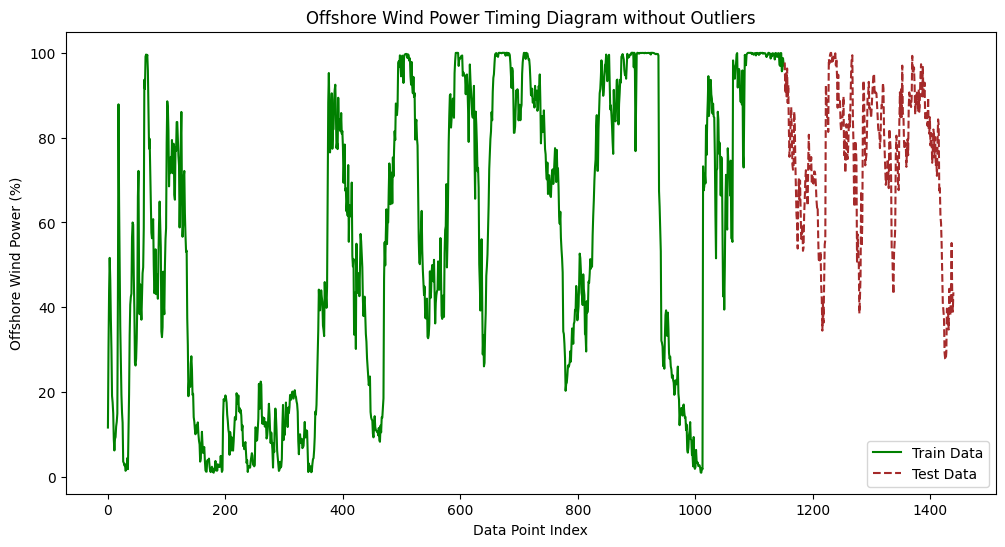

In [11]:
plot_wind_power(train_data, test_data, 'Offshore Wind Power Timing Diagram without Outliers')

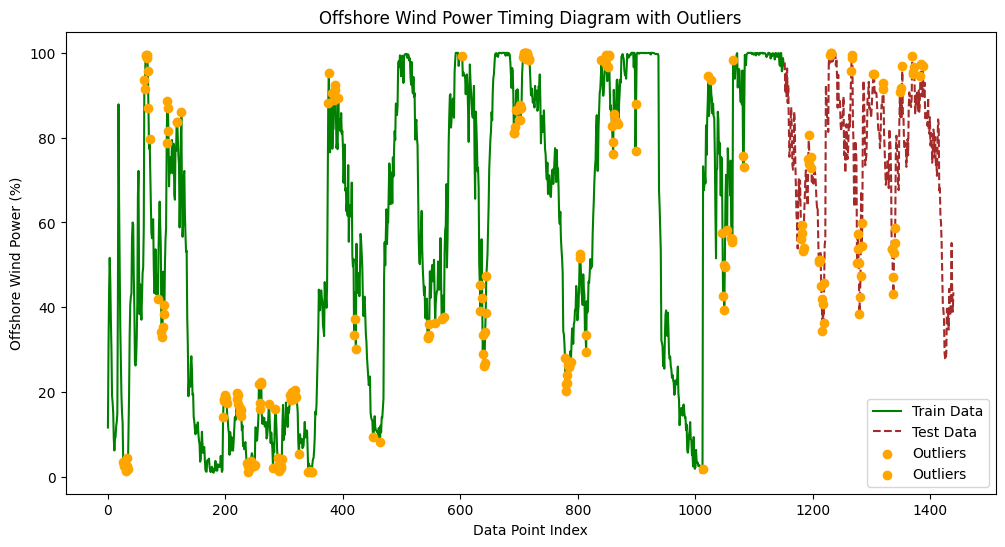

In [12]:
plot_wind_power(train_data, test_data, 'Offshore Wind Power Timing Diagram with Outliers', train_outliers, test_outliers)

In [13]:
scaler = MinMaxScaler()
normalized_train_data = scaler.fit_transform(train_data)
normalized_test_data = scaler.transform(test_data)

In [14]:
normalized_data = pd.DataFrame(np.concatenate([normalized_train_data, normalized_test_data]), columns=['V', 'D', 'air density', 'humidity', 'I', 'S_a', 'S_b', 'y (% relative to rated power)'])
normalized_data

,V,D,air density,humidity,I,S_a,S_b,y (% relative to rated power)
0,0.217331,0.492395,0.123153,0.364671,0.048585,0.092510,0.239459,0.107577
1,0.232441,0.500383,0.119824,0.344900,0.132360,0.051422,0.276517,0.298394
2,0.300583,0.499946,0.106581,0.315538,0.192347,0.128161,0.395848,0.432697
3,0.345379,0.515740,0.126386,0.326397,0.431220,0.214055,0.454584,0.511562
4,0.422605,0.524147,0.079623,0.288296,0.079387,0.061532,0.552580,0.458514
...,...,...,...,...,...,...,...,...
1435,0.427769,0.197270,0.126641,0.325829,0.268118,0.023701,0.274333,0.444041
1436,0.406596,0.201476,0.144397,0.348779,0.324602,0.017794,0.212971,0.546972
1437,0.343280,0.203626,0.148045,0.361826,0.307525,0.127032,0.066561,0.429937
1438,0.342161,0.201668,0.152360,0.372565,0.331630,0.150713,0.074397,0.383184


In [15]:
class DenoisingAutoencoder:
    def __init__(self, input_dim, encoding_dim, hidden_dims=None, activation="relu", learning_rate=0.001):
        hidden_dims = hidden_dims or []
        self.autoencoder = self._build_model(input_dim, encoding_dim, hidden_dims, activation, learning_rate)

    def _build_model(self, input_dim, encoding_dim, hidden_dims, activation, learning_rate):
        encoder_input = Input(shape=(input_dim,))
        x = encoder_input
        for hidden_dim in hidden_dims:
            x = layers.Dense(hidden_dim, activation=activation)(x)
        encoded = layers.Dense(encoding_dim, activation=activation)(x)

        x = encoded
        for hidden_dim in reversed(hidden_dims):
            x = layers.Dense(hidden_dim, activation=activation)(x)
        decoded = layers.Dense(input_dim, activation="sigmoid")(x)

        autoencoder = Model(encoder_input, decoded, name="AutoEncoder")
        autoencoder.compile(optimizer=Adam(learning_rate=learning_rate), loss="mse")
        return autoencoder

    def train(self, X_train, epochs=50, batch_size=64):
        return self.autoencoder.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, verbose=1)

    def denoise(self, X):
        return self.autoencoder.predict(X)

In [16]:
autoencoder = DenoisingAutoencoder(input_dim=normalized_data.shape[1], encoding_dim=2, hidden_dims=[16, 8])
autoencoder.train(normalized_data)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0876
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0794 
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0684 
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0530 
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0446 
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0413 
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0388 
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0372 
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0356 
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0349 
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0324 
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0303 
Epoch 13/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0288 
Epoch 14/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0268 
Epoch 15/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0256 
Epoch

In [17]:
denoised_data = autoencoder.denoise(normalized_data)
unscaled_denoised_data = scaler.inverse_transform(denoised_data)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


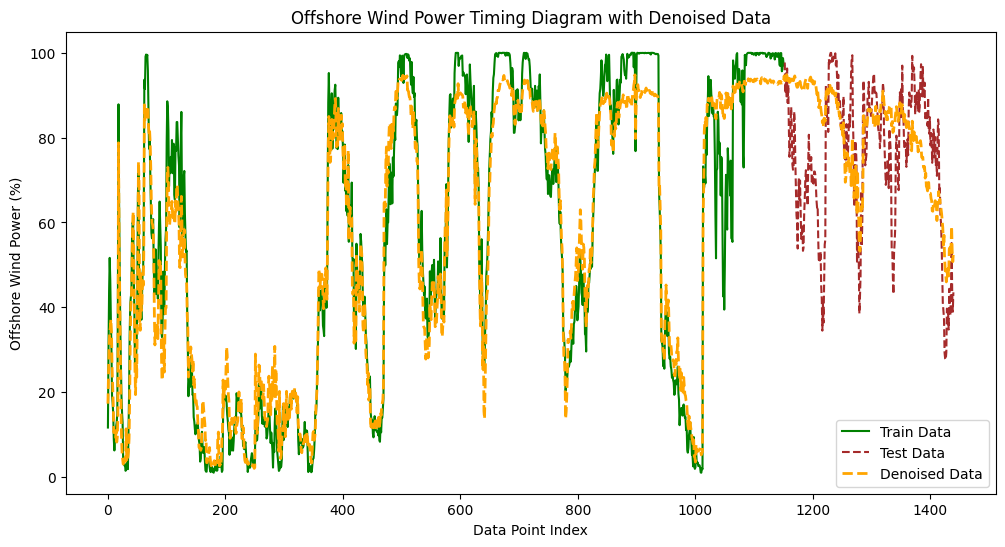

In [18]:
plot_wind_power(train_data, test_data, 'Offshore Wind Power Timing Diagram with Denoised Data', denoised_data=unscaled_denoised_data)

In [19]:
pd.DataFrame(denoised_data, columns=['V', 'D', 'air density', 'humidity', 'I', 'S_a', 'S_b', 'y (% relative to rated power)'])

,V,D,air density,humidity,I,S_a,S_b,y (% relative to rated power)
0,0.201277,0.410150,0.414102,0.545268,0.303012,0.254039,0.356301,0.164401
1,0.246519,0.403198,0.396757,0.543147,0.313505,0.253103,0.334696,0.241034
2,0.281545,0.366221,0.355121,0.503312,0.333957,0.269851,0.335041,0.303591
3,0.299362,0.331177,0.319288,0.462397,0.352578,0.290409,0.344557,0.333818
4,0.302195,0.377362,0.361447,0.519048,0.332457,0.261903,0.320567,0.345059
...,...,...,...,...,...,...,...,...
1435,0.402372,0.291658,0.311676,0.447105,0.365642,0.257335,0.298966,0.541055
1436,0.427338,0.280028,0.330725,0.462272,0.364877,0.235591,0.279488,0.586702
1437,0.394453,0.310600,0.306761,0.451519,0.362764,0.266797,0.304474,0.527605
1438,0.381504,0.311665,0.296627,0.440248,0.364267,0.278320,0.315545,0.502520


In [20]:
pd.DataFrame(unscaled_denoised_data, columns=['V', 'D', 'air density', 'humidity', 'I', 'S_a', 'S_b', 'y (% relative to rated power)'])

,V,D,air density,humidity,I,S_a,S_b,y (% relative to rated power)
0,6.636994,149.486572,1.235738,64.160202,0.069958,0.301727,0.201078,17.280588
1,7.304232,147.409561,1.234760,63.994831,0.071940,0.300618,0.188908,24.869551
2,7.820802,136.362717,1.232412,60.889732,0.075801,0.320471,0.189103,31.064653
3,8.083571,125.893356,1.230391,57.700420,0.079317,0.344839,0.194463,34.057980
4,8.125359,139.691040,1.232769,62.116352,0.075518,0.311050,0.180949,35.171204
...,...,...,...,...,...,...,...,...
1435,9.602777,114.086998,1.229962,56.508469,0.081784,0.305635,0.168782,54.580658
1436,9.970984,110.612686,1.231036,57.690704,0.081639,0.279860,0.157810,59.101093
1437,9.485982,119.745880,1.229685,56.852566,0.081240,0.316850,0.171884,53.248760
1438,9.295007,120.064217,1.229113,55.973999,0.081524,0.330510,0.178120,50.764580


In [21]:
def create_sliding_window(data, prediction_size=1, input_window=144):
    X = [data[i:i + input_window] for i in range(len(data) - input_window - prediction_size + 1)]
    y = [data[i + input_window:i + input_window + prediction_size] for i in range(len(data) - input_window - prediction_size + 1)]
    return np.array(X), np.array(y)

In [22]:
def prepare_data(X, Y):
    X = X[:, :, :-1]
    Y = Y[:, :, :-1]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    y_train = y_train[:, :, -1]
    y_test = y_test[:, :, -1]   
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    X_train_seq = np.expand_dims(X_train, axis=-1)
    X_test_seq = np.expand_dims(X_test, axis=-1)
    return X_train, X_test, y_train, y_test, X_train_flat, X_test_flat, X_train_seq, X_test_seq

In [23]:
X, Y = create_sliding_window(denoised_data)

In [24]:
X_train, X_test, y_train, y_test, X_train_flat, X_test_flat, X_train_seq, X_test_seq = prepare_data(X,Y)

In [25]:
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = tf.abs(error) <= delta
    squared_loss = 0.5 * tf.square(error)
    linear_loss = delta * (tf.abs(error) - 0.5 * delta)
    return tf.reduce_mean(tf.where(is_small_error, squared_loss, linear_loss), axis=-1)

In [26]:
class NeuralNetworkModelBuilder:
    @staticmethod
    def build_mlp(input_dim, hidden_layers=[64, 32], activation='relu', output_dim=1):
        model = models.Sequential([
            layers.Input(shape=(input_dim,)),
            *[layers.Dense(h, activation=activation) for h in hidden_layers],
            layers.Dense(output_dim)
        ])
        return model

    @staticmethod
    def build_rnn(input_dim, hidden_units=64, output_dim=1):
        model = models.Sequential([
            layers.Input(shape=input_dim),
            layers.SimpleRNN(hidden_units, activation='relu', return_sequences=False),
            layers.Dense(output_dim)
        ])
        return model
    
    @staticmethod
    def build_transformer(input_dim, output_dim=1, dropout_rate=0.1, num_heads=4, key_dim=32):
        sequence_length, feature_dim = input_dim
        input_layer = layers.Input(shape=(sequence_length, feature_dim))
    
        embedded_input = layers.Dense(key_dim)(input_layer)
    
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(
            embedded_input, embedded_input
        )
        attention_output = layers.Dropout(dropout_rate)(attention_output)
    
        x = layers.GlobalAveragePooling1D()(attention_output)
        x = layers.Dense(64, activation="relu")(x)
        output_layer = layers.Dense(output_dim)(x)
    
        return models.Model(inputs=input_layer, outputs=output_layer)

In [28]:
class TrainEvaluate:
    def __init__(self, models, loss_functions):
        self.models = models
        self.loss_functions = loss_functions
        self.results = []

    def compute_metrics(self, model_name, loss_name, y_true, y_pred, t):
        mae = np.mean([mean_absolute_error(y_true[:, i], y_pred[:, i]) for i in range(t)])
        mape = np.mean([mean_absolute_percentage_error(y_true[:, i], y_pred[:, i])for i in range(t)])
        rmse = np.mean([np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i])) for i in range(t)])
        r2 = np.mean([1 - np.sum((y_true[:, i] - y_pred[:, i])**2) / np.sum((y_true[:, i] - y_true[:, i].mean())**2) for i in range(t)])

        return {"Model": model_name, "Loss Function": loss_name, "MAE": mae, "RMSE": rmse, "MAPE": mape, "R²": r2}

    def train_and_evaluate(self, X_train_flat, X_train_seq, y_train, X_test_flat, X_test_seq, y_test, t=1):
        for model_name, model_fn in self.models.items():
            for loss_name, loss_fn in self.loss_functions.items():
                print(f"Training {model_name} with {loss_name} loss...")
                model = model_fn()

                model.compile(optimizer='adam', loss=loss_fn, 
                              metrics=[metrics.MeanAbsoluteError(), metrics.MeanAbsolutePercentageError()])
                    
                is_mlp = model_name == "MLP"
                history = model.fit(
                    X_train_flat if is_mlp else X_train_seq, y_train,
                    batch_size=128, epochs=50, shuffle=True
                )

                y_pred = model.predict(X_test_flat if is_mlp else X_test_seq)
                self.results.append(self.compute_metrics(model_name, loss_name, y_test, y_pred, t))

        return self.results


In [29]:
def create_table(data, title="Model Evaluation Results", col_width=10, row_height=0.6, font_size=10, header_color='#40466e',
                 row_colors=['#f1f1f2', 'w'], edge_color='w', bbox=[0, 0, 1, 1], header_fontsize=12):
    df = pd.DataFrame(data)

    display(HTML(df.to_html(index=False)))

    fig, ax = plt.subplots(figsize=(col_width * len(df.columns) / 4, row_height * len(df)))
    ax.axis('tight')
    ax.axis('off')

    mpl_table = ax.table(cellText=df.values, colLabels=df.columns, bbox=bbox, cellLoc='center', loc='center')

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table.get_celld().items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0:
            cell.set_text_props(weight='bold', fontsize=header_fontsize, color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0] % len(row_colors)])

    plt.title(title, fontsize=font_size + 4, weight='bold', pad=20)
    plt.show()

In [30]:
models_dics = {
    "MLP": lambda: NeuralNetworkModelBuilder.build_mlp(input_dim=X_train_flat.shape[1]),
    "RNN": lambda: NeuralNetworkModelBuilder.build_rnn(input_dim=X_train.shape[1:]),
    "Transformer": lambda: NeuralNetworkModelBuilder.build_transformer(input_dim=X_train.shape[1:])
}

loss_functions = {
    "MSE": "mse",
    "Huber": lambda y_true, y_pred: huber_loss(y_true, y_pred)
}

In [31]:
train_evaluate = TrainEvaluate(models_dics, loss_functions)
results = train_evaluate.train_and_evaluate(X_train_flat, X_train_seq, y_train, X_test_flat, X_test_seq, y_test)

Training MLP with MSE loss...
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0395 - mean_absolute_error: 0.1638 - mean_absolute_percentage_error: 114.6803
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0058 - mean_absolute_error: 0.0619 - mean_absolute_percentage_error: 44.2928 
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039 - mean_absolute_error: 0.0502 - mean_absolute_percentage_error: 34.7116 
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0035 - mean_absolute_error: 0.0490 - mean_absolute_percentage_error: 35.8349 
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026 - mean_absolute_error: 0.0388 - mean_absolute_percentage_error: 24.9193 
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0028 - mean_absolute_error: 0.0413 - mean_absolute_percentage_error: 26.5712 
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026 - mean_absolute_error: 0.0415 - mean_absolute_percentage_error: 30.0604 
Epoch 8/50
9/9 ━━━

Model,Loss Function,MAE,RMSE,MAPE,R²
MLP,MSE,0.017650,0.025354,0.107599,0.934795
MLP,Huber,0.025639,0.033005,0.177247,0.889505
RNN,MSE,0.015691,0.021850,0.091316,0.951573
RNN,Huber,0.012820,0.020365,0.074511,0.957930
Transformer,MSE,0.044302,0.054400,0.309340,0.699823
Transformer,Huber,0.038016,0.050759,0.249061,0.738655


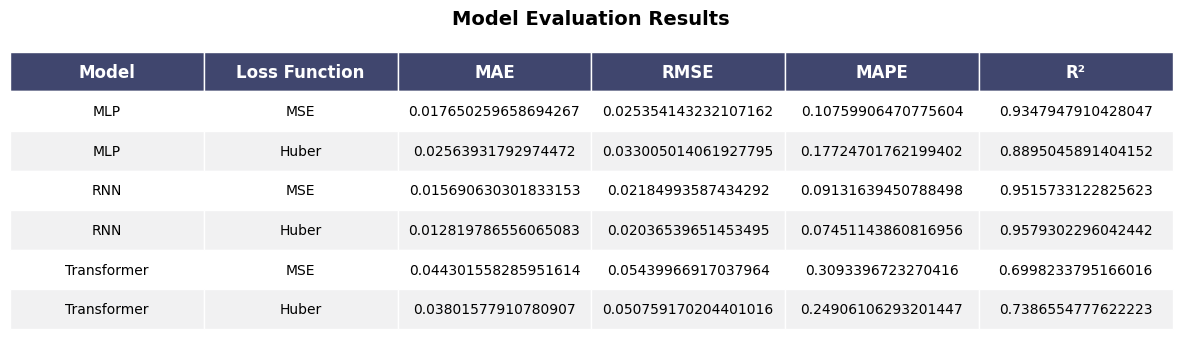

In [32]:
create_table(results)

In [33]:
X_4, Y_4 = create_sliding_window(denoised_data, prediction_size=4, input_window=144)
X_8, Y_8 = create_sliding_window(denoised_data, prediction_size=8, input_window=144)
X_16, Y_16 = create_sliding_window(denoised_data, prediction_size=16, input_window=144)

X_train_4, X_test_4, y_train_4, y_test_4, X_train_flat_4, X_test_flat_4, X_train_seq_4, X_test_seq_4 = prepare_data(X_4, Y_4)
X_train_8, X_test_8, y_train_8, y_test_8, X_train_flat_8, X_test_flat_8, X_train_seq_8, X_test_seq_8 = prepare_data(X_8, Y_8)
X_train_16, X_test_16, y_train_16, y_test_16, X_train_flat_16, X_test_flat_16, X_train_seq_16, X_test_seq_16 = prepare_data(X_16, Y_16)

In [34]:
models_dics_4 = {
    "Transformer": lambda: NeuralNetworkModelBuilder.build_transformer(
    input_dim=X_train_4.shape[1:], 
    output_dim=4)
}

models_dics_8 = {
    "Transformer": lambda: NeuralNetworkModelBuilder.build_transformer(
    input_dim=X_train_8.shape[1:], 
    output_dim=8)
}

models_dics_16 = {
    "Transformer": lambda: NeuralNetworkModelBuilder.build_transformer(
    input_dim=X_train_16.shape[1:], 
    output_dim=16)
}

Training Transformer with MSE loss...
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 251ms/step - loss: 0.0232 - mean_absolute_error: 0.1172 - mean_absolute_percentage_error: 65.8258
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 246ms/step - loss: 0.0102 - mean_absolute_error: 0.0790 - mean_absolute_percentage_error: 55.7942
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 277ms/step - loss: 0.0074 - mean_absolute_error: 0.0676 - mean_absolute_percentage_error: 46.6440
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 277ms/step - loss: 0.0056 - mean_absolute_error: 0.0587 - mean_absolute_percentage_error: 39.0467
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 253ms/step - loss: 0.0046 - mean_absolute_error: 0.0547 - mean_absolute_percentage_error: 38.8268
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 251ms/step - loss: 0.0049 - mean_absolute_error: 0.0559 - mean_absolute_percentage_error: 37.3741
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 253ms/step - loss: 0.0044 - mean_absolute_error: 0.0546 - mean_absolute_percentage_error: 38.7019
Epo

Model,Loss Function,MAE,RMSE,MAPE,R²
Transformer,MSE,0.041573,0.05443,0.282441,0.726879
Transformer,Huber,0.039799,0.05506,0.247221,0.720551


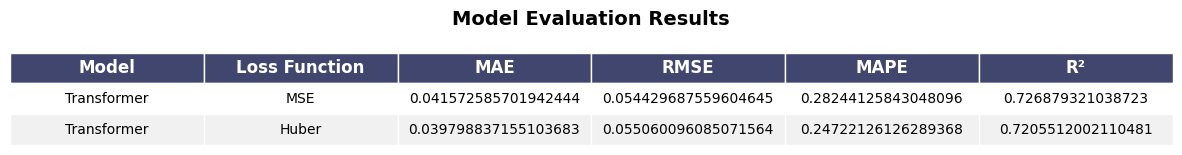

In [35]:
train_evaluate = TrainEvaluate(models_dics_4, loss_functions)
results = train_evaluate.train_and_evaluate(X_train_flat_4, X_train_seq_4, y_train_4, X_test_flat_4, X_test_seq_4, y_test_4, t = 4)

create_table(results)

Training Transformer with MSE loss...
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 243ms/step - loss: 0.0328 - mean_absolute_error: 0.1420 - mean_absolute_percentage_error: 79.0021
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step - loss: 0.0109 - mean_absolute_error: 0.0813 - mean_absolute_percentage_error: 55.8109
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step - loss: 0.0088 - mean_absolute_error: 0.0761 - mean_absolute_percentage_error: 56.2252
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - loss: 0.0066 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 45.4267
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 244ms/step - loss: 0.0055 - mean_absolute_error: 0.0611 - mean_absolute_percentage_error: 44.1571
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 245ms/step - loss: 0.0057 - mean_absolute_error: 0.0620 - mean_absolute_percentage_error: 47.7630
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - loss: 0.0049 - mean_absolute_error: 0.0570 - mean_absolute_percentage_error: 43.0748
Epo

Model,Loss Function,MAE,RMSE,MAPE,R²
Transformer,MSE,0.038952,0.048774,0.280556,0.757907
Transformer,Huber,0.037146,0.048693,0.255845,0.758662


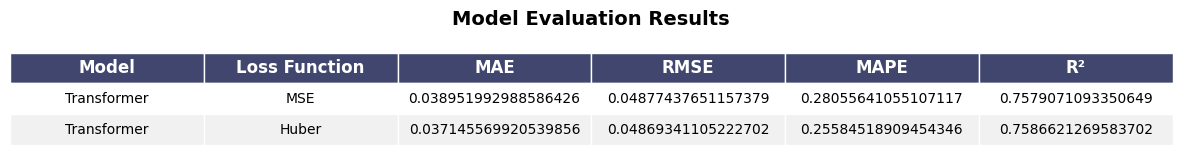

In [36]:
train_evaluate = TrainEvaluate(models_dics_8, loss_functions)
results = train_evaluate.train_and_evaluate(X_train_flat_8, X_train_seq_8, y_train_8, X_test_flat_8, X_test_seq_8, y_test_8, t = 8)

create_table(results)

Training Transformer with MSE loss...
Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 273ms/step - loss: 0.0364 - mean_absolute_error: 0.1578 - mean_absolute_percentage_error: 88.8014
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 266ms/step - loss: 0.0141 - mean_absolute_error: 0.0919 - mean_absolute_percentage_error: 59.3579
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 271ms/step - loss: 0.0108 - mean_absolute_error: 0.0838 - mean_absolute_percentage_error: 59.2209
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 280ms/step - loss: 0.0092 - mean_absolute_error: 0.0752 - mean_absolute_percentage_error: 49.4875
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 273ms/step - loss: 0.0083 - mean_absolute_error: 0.0704 - mean_absolute_percentage_error: 45.5673
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step - loss: 0.0067 - mean_absolute_error: 0.0647 - mean_absolute_percentage_error: 44.6779
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 274ms/step - loss: 0.0058 - mean_absolute_error: 0.0606 - mean_absolute_percentage_error: 42.7564
Epo

Model,Loss Function,MAE,RMSE,MAPE,R²
Transformer,MSE,0.036227,0.048723,0.237504,0.765228
Transformer,Huber,0.038068,0.048974,0.278430,0.762769


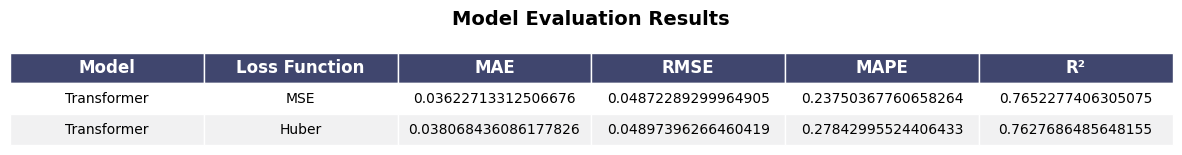

In [37]:
train_evaluate = TrainEvaluate(models_dics_16, loss_functions)
results = train_evaluate.train_and_evaluate(X_train_flat_16, X_train_seq_16, y_train_16, X_test_flat_16, X_test_seq_16, y_test_16, t = 16)

create_table(results)

In [ ]:
class SlimeMouldAlgorithm:
    def __init__(self, objective_function, num_agents, max_iterations, bounds, input_dim, X_train, y_train, X_test, y_test):
        self.objective_function = objective_function
        self.num_agents = num_agents
        self.max_iterations = max_iterations
        self.bounds = bounds
        self.input_dim = input_dim
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        
        self.dimensions = len(bounds)
        self.population = self.initialize_population()
        self.best_position = None
        self.best_fitness = float("inf")

    def initialize_population(self):
        population = []
        for _ in range(self.num_agents):
            agent = [
                np.random.uniform(self.bounds["dropout_rate"].min(), self.bounds["dropout_rate"].max()),
                np.random.choice(self.bounds["num_heads"]),
                np.random.choice(self.bounds["key_dim"]),
            ]
            population.append(agent)
        return np.array(population)

    def fitness(self, position):
        return self.objective_function(position, self.input_dim, self.X_train, self.y_train, self.X_test, self.y_test)

    def update_population(self, fitness_values):
        sorted_indices = np.argsort(fitness_values)
        sorted_population = self.population[sorted_indices]

        best_agent = sorted_population[0]
        best_fitness = fitness_values[sorted_indices[0]]

        if best_fitness < self.best_fitness:
            self.best_position = best_agent
            self.best_fitness = best_fitness

        weight = np.zeros(self.num_agents)
        for i in range(self.num_agents):
            if i < self.num_agents // 2:
                weight[i] = 1 + np.log(1 + (self.best_fitness - fitness_values[sorted_indices[i]]) /
                                       (self.best_fitness - fitness_values[sorted_indices[-1]] + 1e-8))
            else:
                weight[i] = 1 - np.log(1 + (fitness_values[sorted_indices[i]] - fitness_values[sorted_indices[-1]]) /
                                       (self.best_fitness - fitness_values[sorted_indices[-1]] + 1e-8))

        for i in range(self.num_agents):
            if np.random.rand() < 0.8:
                rand_index = np.random.randint(0, self.num_agents)
                self.population[i] += weight[i] * (self.population[rand_index] - self.population[i])
            else:
                rand_position = [
                    np.random.uniform(self.bounds["dropout_rate"].min(), self.bounds["dropout_rate"].max()),
                    np.random.choice(self.bounds["num_heads"]),
                    np.random.choice(self.bounds["key_dim"]),
                ]
                self.population[i] += weight[i] * (rand_position - self.population[i])

        self.population[:, 0] = np.clip(self.population[:, 0], self.bounds["dropout_rate"].min(), self.bounds["dropout_rate"].max())

    def optimize(self):
        for iteration in range(self.max_iterations):
            fitness_values = np.array([self.fitness(agent) for agent in self.population])
            self.update_population(fitness_values)

        return self.best_position, self.best_fitness

In [ ]:
def objective_fn(hyperparams, input_dim, X_train, y_train, X_test, y_test):
    dropout_rate, num_heads, key_dim = hyperparams
    model = NeuralNetworkModelBuilder.build_transformer(
        input_dim=input_dim, 
        output_dim=1, 
        dropout_rate=dropout_rate, 
        num_heads=int(num_heads), 
        key_dim=int(key_dim)
    )
    
    model.compile(optimizer='adam', 
                  loss='mse',
                  metrics=[metrics.MeanAbsoluteError(), metrics.MeanAbsolutePercentageError()])
    
    model.fit(X_train, y_train, epochs=15, batch_size=128, validation_data=(X_test, y_test), verbose=0)
    
    val_loss = model.evaluate(X_test, y_test, verbose=0)[0]
    return val_loss

In [ ]:
bounds = {
    "dropout_rate": np.linspace(0.1, 0.4, 4),
    "num_heads": [4, 8, 16],
    "key_dim": [32, 64, 128],
}

input_dim = X_train.shape[1:]

smoa = SlimeMouldAlgorithm(
    objective_function=objective_fn, 
    num_agents=5, 
    max_iterations=15, 
    bounds=bounds,
    input_dim=input_dim,
    X_train=X_train, 
    y_train=y_train, 
    X_test=X_test, 
    y_test=y_test
)

best_agent, best_fitness = smoa.optimize()

print(f"Best hyperparameters: {best_agent}")
print(f"Best fitness: {best_fitness}")